In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from numpy import pi

6


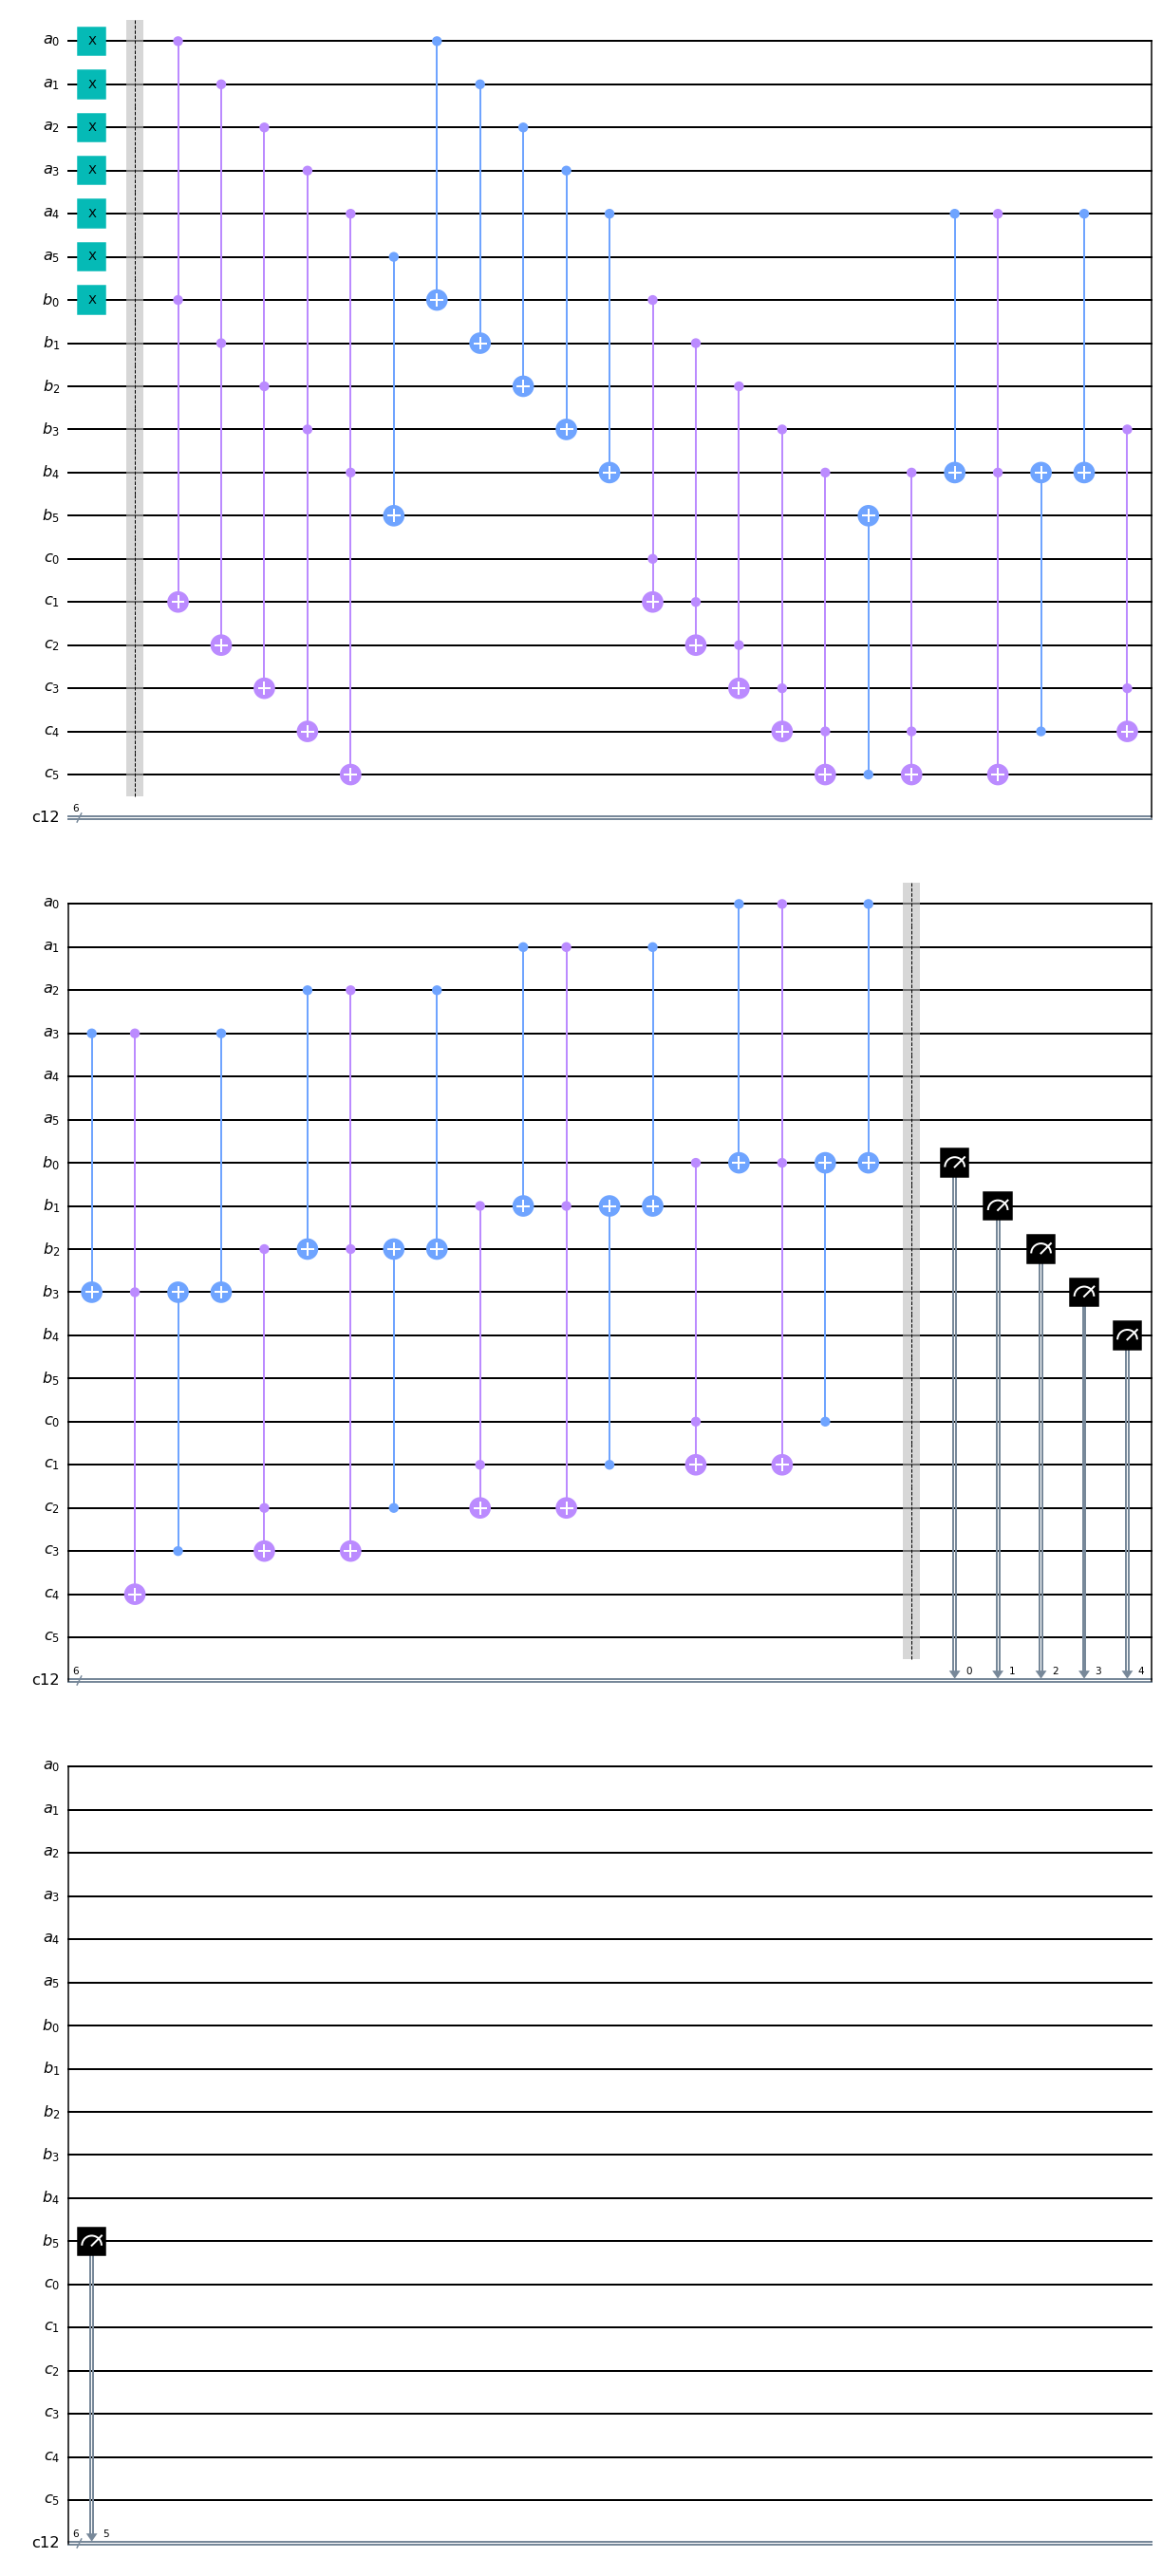

In [28]:
# Addition Circuit Test

# Initilization
n = 3
a = "0001"
b = "0111"

regA = QuantumRegister(n, name="a")
regB = QuantumRegister(n+1, name="b")
regC = QuantumRegister(n, name="c")
output = ClassicalRegister(n+1)

qc = QuantumCircuit(regA, regB, regC, output)


            
initilizeQubits(qc, a, b, regA, regB, n)

cummulativeAdder(qc, regA, regC, regB, n)
qc.measure(regC, output[0:n])
qc.draw(output='mpl')

In [29]:
# Measure
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(qc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
print(counts)

{'000000': 1024}


In [7]:
# Addition Circuit Test With Quantum Output

# Initilization


def adder(qc, regA, regB, regC, outputReg, n):
    qc.barrier()
    for i in range(n):
        
        if (i == 0):
            addBits(qc, regA, regB, outputReg, i)
        else:
            addBits(qc, regA, regB, outputReg, i, regC, i-1)
        getCarryBits(qc, regA, regB, regC, i)
    addOnCarry(qc, regC, outputReg, n-1, n)
    
    for i in range(n):
        getCarryBits(qc, regA, regB, regC, i)
    qc.barrier()
    
def addBits(qc, regA, regB, outputReg, i, regC=None, j=None):
    if (regC == None):
        qc.cx(regA[i], outputReg[i])
        qc.cx(regB[i], outputReg[i])
    else:
        qc.cx(regA[i], outputReg[i])
        qc.cx(regB[i], outputReg[i])
        qc.cx(regC[j], outputReg[i])
            
        
def getCarryBits(qc, regA, regB, regC, i):
    qc.ccx(regA[i], regB[i], regC[i])
    qc.ccx(regA[i], regC[i-1], regC[i])
    qc.ccx(regB[i], regC[i-1], regC[i])
    
def addOnCarry(qc, regC, outputReg, cIndex, oIndex):
    qc.cx(regC[cIndex], outputReg[oIndex])
    
def getCarryBitsCumulative(qc, regA, regB, regC, n):
    for i in range(n-1):
        qc.ccx(regA[i], regB[i], regC[i+1])
        qc.cx(regA[i], regB[i])
        qc.ccx(regC[i], regB[i], regC[i+1])
        
    qc.ccx(regA[n-1], regB[n-1], regB[n])
    qc.cx(regA[n-1], regB[n-1])
    qc.ccx(regC[n-1], regB[n-1], regB[n])
    
def reverseCarryBitsCummulative(qc, regA, regB, regC, n):
    #Reversing the gate operation performed on b[n-1]
    qc.cx(regC[n-1], regB[n-1])
    #Reversing the gate operations performed during the carry gate implementations
    #This is done to ensure the sum gates are fed with the correct input bit states
    for i in range(n-1):
        qc.ccx(regC[(n-2)-i], regB[(n-2)-i], regC[(n-1)-i])
        qc.cx(regA[(n-2)-i], regB[(n-2)-i])
        qc.ccx(regA[(n-2)-i], regB[(n-2)-i], regC[(n-1)-i])
        #These two operations act as a sum gate; if a control bit is at                
        #the 1> state then the target bit b[(n-2)-i] is flipped
        qc.cx(regC[(n-2)-i], regB[(n-2)-i])
        qc.cx(regA[(n-2)-i], regB[(n-2)-i])
def cummulativeAdder(qc, regA, regC, output, n):
    qc.barrier()
    
    print(n, )
    getCarryBitsCumulative(qc, regA, output, regC, n)
    reverseCarryBitsCummulative(qc, regA, output, regC, n)
    qc.barrier()
    
def initilizeQubits(qc, a, b, regA, regB, n):
    for i in range(n):
        if (a[i] == "1"):
            qc.x(regA[n-(i+1)])
        if (b[i] == "1"):
            qc.x(regB[n-(i+1)])
            
def multiplier(qc, regA, regB, regC, auxReg, outputReg, n):
    for i in range(0,n):
        for j in range(n):
            qc.ccx(regA[i], regB[j], auxReg[i + j])
#             qc.measure(auxReg, output)
        cummulativeAdder(qc, auxReg, regC, outputReg, n*2-1)
            # Cleaning Aux
        for j in range(n):
            qc.ccx(regA[i], regB[j], auxReg[i + j])
            
def signedMultiplier(qc, regA, regB, regC, auxReg, outputReg, n, aux2):
    
    # Checking if either are negative numbers
    
    qc.cx(regA[n-1], aux[0])
    qc.cx(regB[n-1], aux[0])
    
    controlledTwosComplement(qc, regA, regC, aux[0])
    controlledTwosComplement(qc, regB, regC, aux[1])
    
    for i in range(0,n):
        for j in range(n):
            qc.ccx(regA[i], regB[j], auxReg[i + j])
#             qc.measure(auxReg, output)
        cummulativeAdder(qc, auxReg, regC, outputReg, n*2-1)
            # Cleaning Aux
        for j in range(n):
            qc.ccx(regA[i], regB[j], auxReg[i + j])
            
    # Revert control registers
    
    controlledTwosComplement(qc, regA, regC, aux[0])
    controlledTwosComplement(qc, regB, regC, aux[1])
    
    qc.cx(aux[1], aux[0])
    
    controlledTwosComplement(qc, outputReg, regC, aux[0])
    
    qc.cx(aux[1], aux[0])
    
    qc.cx(regA[n-1], aux[0])
    qc.cx(regB[n-1], aux[0])
                
def innerProduct(qc, regAs, regBs, regCs, regAuxs, regOs, m, n):
    for i in range(0, m):
        multiplier(qc, regAs[i], regBs[i], regCs[i], regAuxs[i], regOs[i], n)
    for i in range(1, m):
        cummulativeAdder(qc, regOs[i], regCs[0], regOs[0], n*2)
        
# Requires aux and carry axillery registers
def oracleInner(qc, alpha, beta, i, f, d, aux, carry, oAux, output1, output2, n):
    innerProduct(qc, f, d, carry, aux, oAux)
    # Copy output to an aux for multiplication
    qc.cx(oAux[0], aux[0])
    multiplier(qc, oAux[0], aux[0], carry[0], oAux[1], output2, n)
    # Revert aux0
    qc.cx(oAux[0], aux[0])
    # Revert aux and oAux
    innerProduct(qc, f, d, carry, aux, oAux)

In [13]:
# Multiplication Circuit

a = "11"
b = "11"
c = "11"
d = "11"

regAs = []
regBs = []
regCs = []
regAuxs = []
regOs = []
n = 2
m = 2
regAs.append(QuantumRegister(n, name="a0"))
regAs.append(QuantumRegister(n, name="a1"))

regBs.append(QuantumRegister(n, name="b0"))
regBs.append(QuantumRegister(n, name="b1"))

regCs.append(QuantumRegister(n*2, name="c0"))
regCs.append(QuantumRegister(n*2, name="c1"))

regAuxs.append(QuantumRegister(n*2, name="aux0"))
regAuxs.append(QuantumRegister(n*2, name="aux1"))

regOs.append(QuantumRegister(n*2+1, name="out0"))
regOs.append(QuantumRegister(n*2+1, name="out1"))

# regB = QuantumRegister(n, name="b")
# regC = QuantumRegister(n*2, name="c")
# auxReg = QuantumRegister(n*2, name="aux")

# outputReg = QuantumRegister(n*2, name="outputReg")
output = ClassicalRegister(n*2+1)
qc = QuantumCircuit(regAs[0], regAs[1], regBs[0], regBs[1], regCs[0], regCs[1], regAuxs[0], regAuxs[1], regOs[0]
                    , regOs[1], output)


initilizeQubits(qc, a, b, regAs[0], regBs[0], n)
initilizeQubits(qc, c, d, regAs[1], regBs[1], n)
# multiplier(qc, regAs[0], regBs[0], regCs[0], regAuxs[0], regOs[0], n)
innerProduct(qc, regAs, regBs, regCs, regAuxs, regOs, m, n)


qc.measure(regOs[0], output)
# qc.draw()

3
3
3
3
4


In [14]:
# Measure
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(qc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
print(counts)

{'10010': 1024}


In [22]:
n = 2
a = "11"
b = "11"

regA = QuantumRegister(n, name="a")
regB = QuantumRegister(n, name="b")
regC = QuantumRegister(n*2, name="c")
regAux = QuantumRegister(n*2, name="aux")
regO = QuantumRegister(n*2, name="o")
output = ClassicalRegister(n*2)

qc = QuantumCircuit(regA, regB, regC, regAux, regO, output)
qc.h(regA)
qc.h(regB)
# initilizeQubits(qc, a, b, regA, regB, n)
multiplier(qc, regA, regB, regC, regAux, regO, n)

qc.measure(regO, output)
# Measure
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(qc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
print(counts)
# qc.draw(output='mpl')

3
3
{'1000': 65, '1001': 73, '1101': 75, '1111': 64, '0110': 58, '1011': 60, '0101': 59, '0011': 61, '0000': 75, '0111': 67, '0010': 64, '1010': 57, '0001': 70, '1110': 66, '0100': 44, '1100': 66}


In [2]:
"""
Shift Adder Multiplication Circuit

Multiplies two n bit registers regA and regB using a shift adder and
stores the result in a 2*n bit output register.

Qubits [0 : n] are for regA
Qubits [n : 2*n] are for regB
Qubits [2*n : 4*n] are for an ancilla register
Qubits [4*n : 6*n+1] are for the output register
Qubits [6*n+1 : 8*n+1] are for the carry register regC

Total Qubits required = 8*n + 1

Paramters: n

"""

"""
Cumulative Adder Circuit

Adds two n bit strings from reg A and B and store them in reg B
Reg B and Reg Cmust be of size n+1

Qubits [0 : n] are for regA
Qubits [n : 2*n+1] are for regB
Qubits [2*n+1 : 3*n+1] are for the carry register regC

Total Qubits required = 3*n + 1

Paramters: n

"""

"""
Signed Shift Adder Multiplication Circuit

Multiplies two n bit registers regA and regB using a shift adder and
stores the result in a 2*n bit output register.

Qubits [0 : n] are for regA
Qubits [n : 2*n] are for regB
Qubits [2*n : 4*n] are for an ancilla register
Qubits [4*n : 6*n] are for the output register
Qubits [6*n : 8*n] are for the carry register regC
Qubits [8*n : 8*n+2] are for more ancilla bits

Total Qubits required = 8*n + 2

Paramters: n

"""

"""
Oracle 1' Circuit

Computes the inner product of two row vectors of length k
Works with signed numbers
Brings the state |f>|d>|0> -> |f>|d>|(d.f)>

Qubits [0 : n*k] are for the row vector f
Qubits [n*k : 2*n*k] are for the row vector d
Qubits [2*n*k : 2*n*k + 2*n] are for carry bits
Qubits [2*n*k + 2*n : 2*n*k + 4*n] are for ancilla bits
Qubits [2*n*k + 4*n : 4*n*k + 4*n] are for the output registers
Qubits [4*n*k + 4*n : 4*n*k + 4*n + 2] are for control qubits

Total Qubits required = 4*n*k + 4*n + 2

Paramters: n

"""

"\nOracle 1' Circuit\n\nComputes the inner product of two row vectors of length k\nWorks with signed numbers\nBrings the state |f>|d>|0> -> |f>|d>|(d.f)>\n\nQubits [0 : n*k] are for the row vector f\nQubits [n*k : 2*n*k] are for the row vector d\nQubits [2*n*k : 2*n*k + 2*n] are for carry bits\nQubits [2*n*k + 2*n : 2*n*k + 4*n] are for ancilla bits\nQubits [2*n*k + 4*n : 4*n*k + 4*n] are for the output registers\nQubits [4*n*k + 4*n : 4*n*k + 4*n + 2] are for control qubits\n\nTotal Qubits required = 4*n*k + 4*n + 2\n\nParamters: n\n\n"

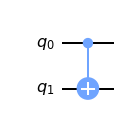

In [3]:
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.draw('mpl')

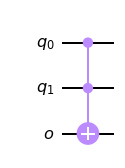

In [8]:
q = QuantumRegister(2, "q")
anc = QuantumRegister(1, "o")

qc = QuantumCircuit(q, anc)

qc.ccx(0, 1, 2)

qc.draw('mpl')

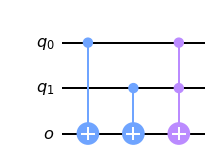

In [9]:
q = QuantumRegister(2, "q")
anc = QuantumRegister(1, "o")

qc = QuantumCircuit(q, anc)
qc.cx(0, 2)
qc.cx(1,2)
qc.ccx(0, 1, 2)

qc.draw('mpl')